In [1]:
import pickle
import sys
from collections import defaultdict
from pathlib import Path

import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.cluster.hierarchy as sch
import seaborn as sns
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, zoomed_inset_axes
from skimage import measure, exposure
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from typing import List
import skimage

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Import path
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
import utils as utils
from config import *

In [5]:
csv_file = data_meta / "info_combined.csv"

# Read dataframe containing images information
df = pd.read_csv(csv_file)

# VIz

In [6]:
def create_HM(
    df_per_label, my_cmap, scale_name, cellSizePixels=25, **kwargs
):
    # Calulate the figure size, this gets us close, but not quite to the right place
    dpi = matplotlib.rcParams["figure.dpi"]
    marginWidth = (
        matplotlib.rcParams["figure.subplot.right"]
        - matplotlib.rcParams["figure.subplot.left"]
    )
    marginHeight = (
        matplotlib.rcParams["figure.subplot.top"]
        - matplotlib.rcParams["figure.subplot.bottom"]
    )
    Ny, Nx = df_per_label.shape
    figWidth = (Nx * cellSizePixels / dpi) / marginWidth
    figHeigh = (Ny * cellSizePixels / dpi) / marginHeight

    ax = sns.clustermap(
        df_per_label,
        cbar_kws={"fraction": 0.01},
        cmap=my_cmap,
        linewidth=0.1,
        dendrogram_ratio=(0.1, 0.1),
        figsize=(figWidth, figHeigh),
        **kwargs,
    )
    ax.ax_heatmap.set_yticklabels(ax.ax_heatmap.get_yticklabels(), rotation=0)
    ax.ax_heatmap.set_xticklabels(
        ax.ax_heatmap.get_xticklabels(), rotation=45, horizontalalignment="right"
    )
    ax.ax_heatmap.set_xlabel("Marker")
    ax.ax_heatmap.set_ylabel("Marker")

    # calculate the size of the heatmap axes
    axWidth = (Nx * cellSizePixels) / (figWidth * dpi)
    axHeight = (Ny * cellSizePixels) / (figHeigh * dpi)

    # resize heatmap
    ax_heatmap_orig_pos = ax.ax_heatmap.get_position()
    ax.ax_heatmap.set_position(
        [ax_heatmap_orig_pos.x0, ax_heatmap_orig_pos.y0, axWidth, axHeight]
    )

    # resize dendrograms to match
    ax_row_orig_pos = ax.ax_row_dendrogram.get_position()
    ax.ax_row_dendrogram.set_position(
        [ax_row_orig_pos.x0, ax_row_orig_pos.y0, ax_row_orig_pos.width, axHeight]
    )
    ax_col_orig_pos = ax.ax_col_dendrogram.get_position()
    ax.ax_col_dendrogram.set_position([ax_col_orig_pos.x0, ax_heatmap_orig_pos.y0+axHeight,
                                         axWidth, ax_col_orig_pos.height])

    # Change colorbar label position
    cbar = ax.ax_heatmap.collections[0].colorbar
    cbar.set_label(scale_name, fontsize=12)
    
    pos = ax.ax_heatmap.get_position()
    cbar_size=0.2
    ax.ax_cbar.set_position((1.1, pos.y0, .03, cbar_size))

    for _, spine in ax.ax_heatmap.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(3)

# Per cell

In [7]:
df_intensity = pd.read_csv(data_meta / "measurements_intensity.csv")
df_morph = pd.read_csv(data_meta / "measurements_morphology.csv")
markers = df_intensity.Marker.unique()

In [8]:
# Calculate total intensity from mena intensity and area size
for row in df_intensity.itertuples():
    cond = row.Location
    i = row.Id
    total_nuclei_intensity = (
        row.Nuclei_mean_intensity
        * df_morph[(df_morph.Location == cond) & (df_morph.Id == i)][
            "Nuclei_area"
        ].item()
    )
    total_cyto_intensity = (
        row.Cyto_mean_intensity
        * df_morph[(df_morph.Location == cond) & (df_morph.Id == i)]["Cyto_area"].item()
    )
    df_intensity.loc[row.Index, "Nuclei_total_intensity"] = total_nuclei_intensity
    df_intensity.loc[row.Index, "Cyto_total_intensity"] = total_cyto_intensity

In [9]:
df_intensity.replace('Hoeschst', 'DAPI', inplace=True)
df_intensity

,Cell_mean_intensity,Nuclei_mean_intensity,Cyto_mean_intensity,Marker,Location,Id,Nuclei_total_intensity,Cyto_total_intensity
0,11788.158099,32185.806775,567.825916,DAPI,1,1,144417715.0,4631756.0
1,7382.506802,12458.758859,4590.163663,p-EGFR,1,1,55902451.0,37441965.0
2,10368.843246,20900.001337,4575.867108,Concanavalin A,1,1,93778306.0,37325348.0
3,8268.703417,9150.794295,7783.483143,PCNA,1,1,41059614.0,63489872.0
4,11672.761784,27605.816136,2908.312247,B-actin,1,1,123867297.0,23723103.0
...,...,...,...,...,...,...,...,...
93334,5692.377801,7927.878788,5606.558568,B-tubin,9,53,3401060.0,62653292.0
93335,3570.571269,3431.109557,3575.925101,Cyclin D1,9,53,1471946.0,39960963.0
93336,1343.401586,13554.449883,874.628456,H3k27me3-488,9,53,5814859.0,9773973.0
93337,2495.286281,3918.272727,2440.658881,H3k4me3-647,9,53,1680939.0,27274363.0


In [10]:
# df_intensity = df_intensity[~df_intensity.Marker.isin(['PCNA', 'DAPI', 'WGA', 'B-tubin', 'Concanavalin A', 'Phalloidin', 'B-actin'])]
df_intensity = df_intensity[~df_intensity.Marker.isin(['PCNA', 'B-tubin', 'B-actin'])]
# df_intensity = df_intensity[~df_intensity.Marker.isin(['DAPI', 'WGA', 'Concanavalin A', 'Phalloidin', 'PCNA'])]

In [11]:
df_cell = df_intensity[['Marker', 'Location', 'Id']]
# df_cell['Intensity'] = df_intensity.iloc[:,-2] + df_intensity.iloc[:,-1]
df_cell['Intensity'] = df_intensity.iloc[:,0]
df_cell = df_cell.pivot(index=['Location','Id'], columns='Marker', values="Intensity")

C:\Users\thu71\AppData\Local\Temp/ipykernel_124712/3772680997.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cell['Intensity'] = df_intensity.iloc[:,0]


In [12]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# x_scaled = scaler.fit_transform(np.log(df_cell+1))
# x_scaled = scaler.fit_transform(x_scaled.T).T
# df_cell = pd.DataFrame(
#     x_scaled, index=df_cell.index, columns=df_cell.columns
# )

In [13]:
def get_data_per_condition_mean(df, scaler, condition=None):
    # Read information
    df_list = []
    df_cell_intensity = df.iloc[:,[1, 3, 4, 5]]
    if condition:
        df_subset = df_cell_intensity[df_cell_intensity.Location == condition]
        df_subset.drop(["Location"], axis=1, inplace=True)
    else:
        df_subset = df_cell_intensity.iloc[:, [0,-1]]
        df_subset["Marker"] = df.Marker
        df_subset["Id"] = df.Location.astype(str) + "_" + df.Id.astype(str)
        
    df_subset.rename(columns={"Nuclei_mean_intensity": "Intensity"}, inplace=True)
    df_subset["Location"] = "Nuclei"
    df_list.append(df_subset)

    df_cell_intensity = df.iloc[:, 2:6]
    if condition:
        df_subset = df_cell_intensity[df_cell_intensity.Location == condition]
        df_subset.drop(["Location"], axis=1, inplace=True)
    else:
        df_subset = df_cell_intensity.iloc[:, [0,-1]]
        df_subset["Marker"] = df.Marker
        df_subset["Id"] = df.Location.astype(str) + "_" + df.Id.astype(str)
    df_subset.rename(columns={"Cyto_mean_intensity": "Intensity"}, inplace=True)
    df_subset["Location"] = "Cyto"
    df_list.append(df_subset)

    df_subset = pd.concat(df_list)

    # Pivot the dataframe
    df_per_cell = (
        df_subset.set_index(["Id", "Marker", "Location"])
        .unstack()
        .unstack()
        .droplevel(0, axis=1)
    )

    # Scale the data
    x_scaled = scaler.fit_transform(np.log(df_per_cell+1))
    x_scaled = scaler.fit_transform(x_scaled.T).T
    df_per_cell_scaled = pd.DataFrame(
        x_scaled, index=df_per_cell.index, columns=df_per_cell.columns
    )

    return df_per_cell_scaled

def get_data_per_condition(df, scaler, condition=None):
    # Read information
    df_list = []
    df_cell_intensity = df.iloc[:, 3:-1]
    if condition:
        df_subset = df_cell_intensity[df_cell_intensity.Location == condition]
        df_subset.drop(["Location"], axis=1, inplace=True)
    else:
        df_subset = df_cell_intensity.iloc[:, -2:]
        df_subset["Marker"] = df.Marker
        df_subset["Id"] = df.Location.astype(str) + "_" + df.Id.astype(str)
    
    df_subset.rename(columns={"Nuclei_total_intensity": "Intensity"}, inplace=True)
    df_subset["Location"] = "Nuclei"
    df_list.append(df_subset)

    df_cell_intensity = df.iloc[:, [3, 4, 5, 7]]
    if condition:
        df_subset = df_cell_intensity[df_cell_intensity.Location == condition]
        df_subset.drop(["Location"], axis=1, inplace=True)
    else:
        df_subset = df_cell_intensity.iloc[:, -2:]
        df_subset["Marker"] = df.Marker
        df_subset["Id"] = df.Location.astype(str) + "_" + df.Id.astype(str)
    df_subset.rename(columns={"Cyto_total_intensity": "Intensity"}, inplace=True)
    df_subset["Location"] = "Cyto"
    df_list.append(df_subset)

    df_subset = pd.concat(df_list)

    # Pivot the dataframe
    df_per_cell = (
        df_subset.set_index(["Id", "Marker", "Location"])
        .unstack()
        .unstack()
        .droplevel(0, axis=1)
    )

    # Scale the data
    x_scaled = scaler.fit_transform(np.log(df_per_cell+1))
    x_scaled = scaler.fit_transform(x_scaled.T).T
    df_per_cell_scaled = pd.DataFrame(
        x_scaled, index=df_per_cell.index, columns=df_per_cell.columns
    )

    return df_per_cell

In [14]:
scaler = StandardScaler()
df_per_cell_scaled = get_data_per_condition_mean(df_intensity, scaler)


C:\Users\thu71\AppData\Local\Temp/ipykernel_124712/2583124952.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["Marker"] = df.Marker
C:\Users\thu71\AppData\Local\Temp/ipykernel_124712/2583124952.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["Id"] = df.Location.astype(str) + "_" + df.Id.astype(str)
C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See t

In [15]:
df_cell

Marker                AKT          APC        AXIN1  Concanavalin A  \
Location Id                                                           
1        1   14459.277839  4117.120452  7744.916482    10368.843246   
         2    7160.933019  1934.098656  3793.797978     8553.532993   
         3   14383.487367  2870.144156  9827.050390     5919.280438   
         4   11151.202655  2124.724139  7811.664020     3832.709543   
         5   10927.639716  2646.010169  8434.039903    11369.864142   
...                   ...          ...          ...             ...   
63       53  10136.236003  2434.936385  6488.919009     2564.259688   
         54   9850.039718  4334.232444  6348.863859     5961.675200   
         55   6685.835827  2919.287702  5177.098184    14069.926824   
         56   8930.734507  3267.864471  6226.894218     1678.361309   
         57    990.641933  1622.219949   900.659317     3741.932690   

Marker          Cyclin D1     Cyclin E          DAPI          DKK1  \
Location Id                                                          
1        1    5743.423600  3379.050538  11788.158099   6573.061689   
         2    3351.268355  3175.795558   8972.935958   4304.790804   
         3    7127.572973  5481.962780   5168.164519   7331.734736   
         4    6139.919128  2543.786528   3564.201348   4376.169398   
         5    5930.281443  4603.990658   8138.127756   5502.827271   
...                   ...          ...           ...           ...   
63       53   4578.727268  2277.486321   7191.501154   6160.775627   
         54   3907.958488  3905.006939   7433.551083   8233.922539   
         55  12809.086037  3605.053169   5945.409760  10492.135970   
         56   4360.724642  2500.160368   4926.443163   7368.286892   
         57    237.062010   654.918062   3222.119462   5789.383400   

Marker               DKK2          EGFR  ...  Non-p-B-catenin   Phalloidin  \
Location Id                              ...                                 
1        1   15301.175736  12244.989007  ...     11827.865549  9937.847438   
         2    7567.280671   6742.909382  ...      6419.993475  2634.282961   
         3   14571.916362  14858.660010  ...      9779.228187  7726.513957   
         4    9945.527320  10228.566353  ...      4949.686805  5823.863692   
         5   12115.959546  11930.591187  ...      7149.544753  6094.225502   
...                   ...           ...  ...              ...          ...   
63       53   8626.826718  12376.610444  ...      8757.451241  5438.656025   
         54   8171.467520  11924.788671  ...      8628.073334  4314.737708   
         55   7281.235247  15687.945402  ...      8071.008448  3875.741005   
         56   7755.240148  15542.552537  ...      9359.213740  3631.173724   
         57    368.936082   4877.666525  ...       557.617554   709.594870   

Marker             RNF 43           WGA         Wnt1         mTOR  \
Location Id                                                         
1        1    8755.751661  10614.561452  4884.073711  7014.683328   
         2    4280.926494   5364.704810  3860.029212  4851.922562   
         3   11723.020614   6701.320628  5893.357920  9733.058872   
         4    7291.795895   1911.319090  3180.551591  6393.564832   
         5    8321.789131   5061.344439  3760.146825  7669.969439   
...                   ...           ...          ...          ...   
63       53   6698.504732   4161.157367  2496.124594  5742.007016   
         54   8950.885872   5456.206065  5871.533258  7978.642601   
         55   9732.408709  13006.786441  9195.717846  8464.063635   
         56  10042.963373   3070.413619  3994.695503  8409.880255   
         57   6233.785245   9921.266589  4762.410960  4596.129425   

Marker             p-AKT   p-B-catenin       p-EGFR        p-mTOR  
Location Id                                                        
1        1   4419.006723   8607.382395  7382.506802   8611.225799  
         2   1770.325872   3041.209412  3824.207

In [16]:
df_per_cell_scaled

Location      Cyto                                                         \
Marker         AKT       APC     AXIN1 Concanavalin A Cyclin D1  Cyclin E   
Id                                                                          
10_1      0.006649 -1.662095 -0.958505      -0.398831 -0.061113  0.651403   
10_10     0.251679 -1.686797 -1.021482      -1.792831  0.601719  1.123261   
10_11     0.194031 -2.431741 -1.278736      -0.027350  0.931886  0.746895   
10_12    -0.206696 -0.846651 -2.547637       0.558721  0.510433  1.478110   
10_13    -1.185758  0.960687 -1.251896       0.611100 -1.571622  1.138707   
...            ...       ...       ...            ...       ...       ...   
9_53     -0.864252 -0.704006  0.133963      -1.058311 -0.937099 -0.264622   
9_6      -1.153524 -0.637426 -0.973523       0.994153 -0.533673  1.184418   
9_7       0.062813  0.321805  0.179171       0.468478  0.849427  0.515088   
9_8       0.412197  0.070567  0.669874      -0.882373  1.145941 -0.184185   
9_9       0.584504 -1.606282  0.770589      -1.130492  1.205505  0.652470   

Location                                          ...          Nuclei  \
Marker        DAPI      DKK1      DKK2      EGFR  ... Non-p-B-catenin   
Id                                                ...                   
10_1      0.918481  0.571403  0.748868  1.438308  ...       -0.624193   
10_10    -2.894136  0.440817  0.696258  0.892435  ...       -0.846451   
10_11    -1.393824  0.343843  1.191213  0.899186  ...       -0.843087   
10_12    -0.354433  1.114555  1.036909  1.092278  ...       -1.309159   
10_13     0.395237  0.285341 -0.570805 -1.779375  ...        0.271409   
...            ...       ...       ...       ...  ...             ...   
9_53     -0.530055  0.017199  0.457265  1.062347  ...       -0.645960   
9_6      -0.633550  0.384261 -0.252774 -0.094393  ...       -0.845691   
9_7      -2.864654  0.111517  0.110122  0.170872  ...       -0.754695   
9_8      -1.013147 -1.777845  0.537987 -0.359198  ...       -0.407160   
9_9      -1.746168 -1.244470  0.527206 -0.159173  ...       -0.219714   

Location                                                               \
Marker   Phalloidin    RNF 43       WGA      Wnt1      mTOR     p-AKT   
Id                                                                      
10_1      -0.064226  1.390852 -0.359090 -0.353591  0.510448  0.521430   
10_10      0.172035  0.885667 -0.042419  0.366526  0.485123  0.579236   
10_11      0.811075  0.726900 -0.230590 -0.803978  0.525074  0.631010   
10_12      0.374940  0.557523  0.006588 -0.193501  0.030549  0.047795   
10_13      0.796032 -1.620283  0.808867  0.384251 -0.199211  1.072049   
...             ...       ...       ...       ...       ...       ...   
9_53      -0.650340  1.300343  0.601007  2.383810  1.247030 -0.012381   
9_6        0.343582  0.978895  0.701395  1.873988 -0.367128  1.771447   
9_7        0.943179 -1.160261  2.134968 -2.626885 -1.230619 -0.297916   
9_8        1.304194 -0.724308 -1.052882 -2.711070 -0.311239  0.141455   
9_9        0.932202 -0.709974  0.666710 -2.027554 -0.520195  0.162214   

Location                                  
Marker   p-B-catenin    p-EGFR    p-mTOR  
Id                                        
10_1        0.138676 -0.010339 -0.111409  
10_10       0.818532 -0.193335  0.517238  
10_11       0.949143 -0.764064  0.572229  
10_12       0.228554 -1.048960 -0.484634  
10_13      -1.155605  1.194958 -0.865434  
...              ...       ...       ...  
9_53        0.279942  0.176599 -0.775395  
9_6        -0.087923  1.289942 -0.550082  
9_7         0.299984  1.999400 -0.094437  
9_8         1.007991  0.357175  0.570647  
9_9         1.053728  0.461929  0.706518  

[3457 rows x 48 columns]

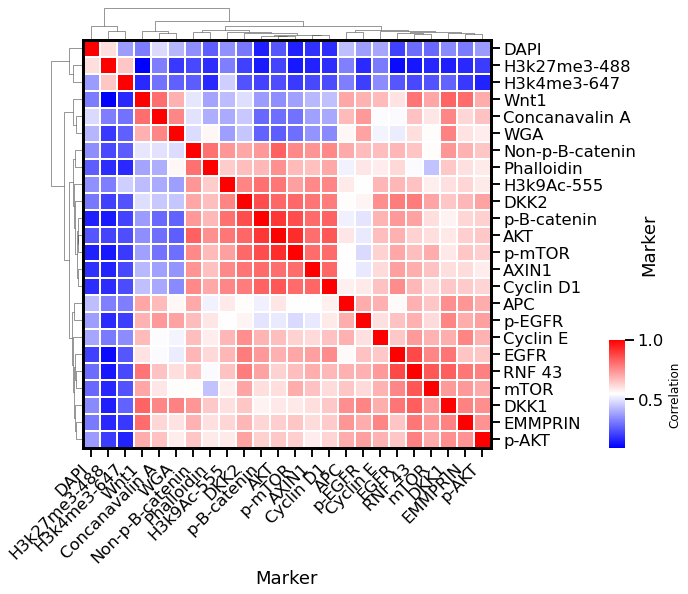

In [17]:
sns.set_context("talk")

create_HM(df_cell.corr(), 'bwr', 'Correlation', vmax=1, cellSizePixels=17, xticklabels=True, yticklabels=True)

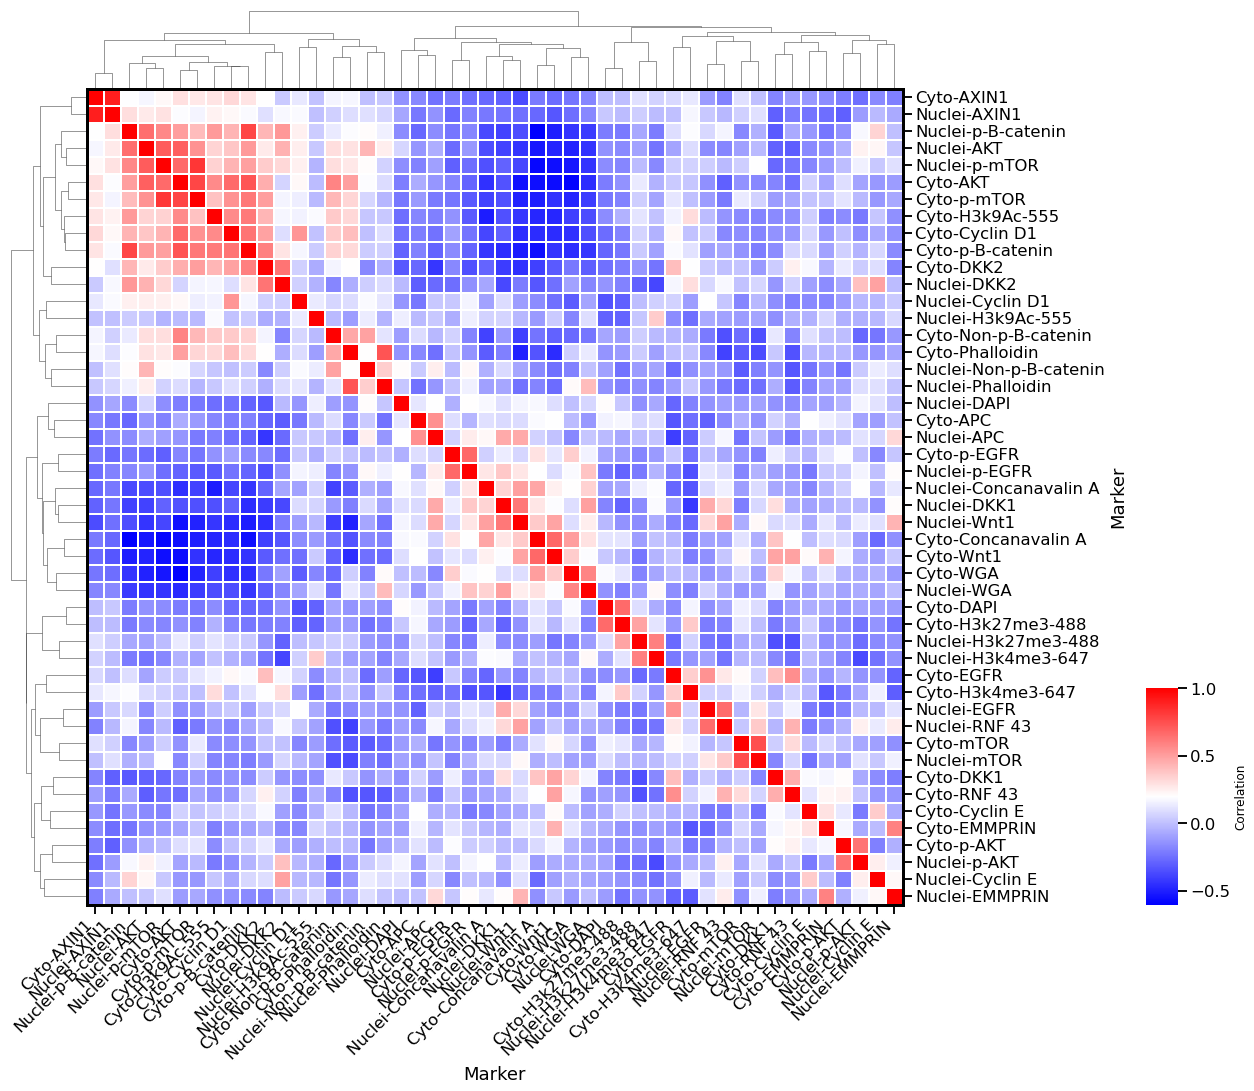

In [18]:
create_HM(df_per_cell_scaled.corr(), 'bwr', 'Correlation', vmax=1, cellSizePixels=17, xticklabels=True, yticklabels=True)


In [19]:
from scipy.stats import pearsonr
import statsmodels.stats.multitest as smm

pval = df_cell.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(len(df_cell.columns))
p_values = pval.values.flatten()

rej, pval_corr, _, _ = smm.multipletests(p_values)
print(pval_corr)

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

# 3 Way correlation

In [20]:
df_cell

Marker                AKT          APC        AXIN1  Concanavalin A  \
Location Id                                                           
1        1   14459.277839  4117.120452  7744.916482    10368.843246   
         2    7160.933019  1934.098656  3793.797978     8553.532993   
         3   14383.487367  2870.144156  9827.050390     5919.280438   
         4   11151.202655  2124.724139  7811.664020     3832.709543   
         5   10927.639716  2646.010169  8434.039903    11369.864142   
...                   ...          ...          ...             ...   
63       53  10136.236003  2434.936385  6488.919009     2564.259688   
         54   9850.039718  4334.232444  6348.863859     5961.675200   
         55   6685.835827  2919.287702  5177.098184    14069.926824   
         56   8930.734507  3267.864471  6226.894218     1678.361309   
         57    990.641933  1622.219949   900.659317     3741.932690   

Marker          Cyclin D1     Cyclin E          DAPI          DKK1  \
Location Id                                                          
1        1    5743.423600  3379.050538  11788.158099   6573.061689   
         2    3351.268355  3175.795558   8972.935958   4304.790804   
         3    7127.572973  5481.962780   5168.164519   7331.734736   
         4    6139.919128  2543.786528   3564.201348   4376.169398   
         5    5930.281443  4603.990658   8138.127756   5502.827271   
...                   ...          ...           ...           ...   
63       53   4578.727268  2277.486321   7191.501154   6160.775627   
         54   3907.958488  3905.006939   7433.551083   8233.922539   
         55  12809.086037  3605.053169   5945.409760  10492.135970   
         56   4360.724642  2500.160368   4926.443163   7368.286892   
         57    237.062010   654.918062   3222.119462   5789.383400   

Marker               DKK2          EGFR  ...  Non-p-B-catenin   Phalloidin  \
Location Id                              ...                                 
1        1   15301.175736  12244.989007  ...     11827.865549  9937.847438   
         2    7567.280671   6742.909382  ...      6419.993475  2634.282961   
         3   14571.916362  14858.660010  ...      9779.228187  7726.513957   
         4    9945.527320  10228.566353  ...      4949.686805  5823.863692   
         5   12115.959546  11930.591187  ...      7149.544753  6094.225502   
...                   ...           ...  ...              ...          ...   
63       53   8626.826718  12376.610444  ...      8757.451241  5438.656025   
         54   8171.467520  11924.788671  ...      8628.073334  4314.737708   
         55   7281.235247  15687.945402  ...      8071.008448  3875.741005   
         56   7755.240148  15542.552537  ...      9359.213740  3631.173724   
         57    368.936082   4877.666525  ...       557.617554   709.594870   

Marker             RNF 43           WGA         Wnt1         mTOR  \
Location Id                                                         
1        1    8755.751661  10614.561452  4884.073711  7014.683328   
         2    4280.926494   5364.704810  3860.029212  4851.922562   
         3   11723.020614   6701.320628  5893.357920  9733.058872   
         4    7291.795895   1911.319090  3180.551591  6393.564832   
         5    8321.789131   5061.344439  3760.146825  7669.969439   
...                   ...           ...          ...          ...   
63       53   6698.504732   4161.157367  2496.124594  5742.007016   
         54   8950.885872   5456.206065  5871.533258  7978.642601   
         55   9732.408709  13006.786441  9195.717846  8464.063635   
         56  10042.963373   3070.413619  3994.695503  8409.880255   
         57   6233.785245   9921.266589  4762.410960  4596.129425   

Marker             p-AKT   p-B-catenin       p-EGFR        p-mTOR  
Location Id                                                        
1        1   4419.006723   8607.382395  7382.506802   8611.225799  
         2   1770.325872   3041.209412  3824.207

In [21]:
df_cell.columns

Index(['AKT', 'APC', 'AXIN1', 'Concanavalin A', 'Cyclin D1', 'Cyclin E',
       'DAPI', 'DKK1', 'DKK2', 'EGFR', 'EMMPRIN', 'H3k27me3-488',
       'H3k4me3-647', 'H3k9Ac-555', 'Non-p-B-catenin', 'Phalloidin', 'RNF 43',
       'WGA', 'Wnt1', 'mTOR', 'p-AKT', 'p-B-catenin', 'p-EGFR', 'p-mTOR'],
      dtype='object', name='Marker')

0.8835421210119591


Text(0.5, 0.92, 'R^2: 0.88')

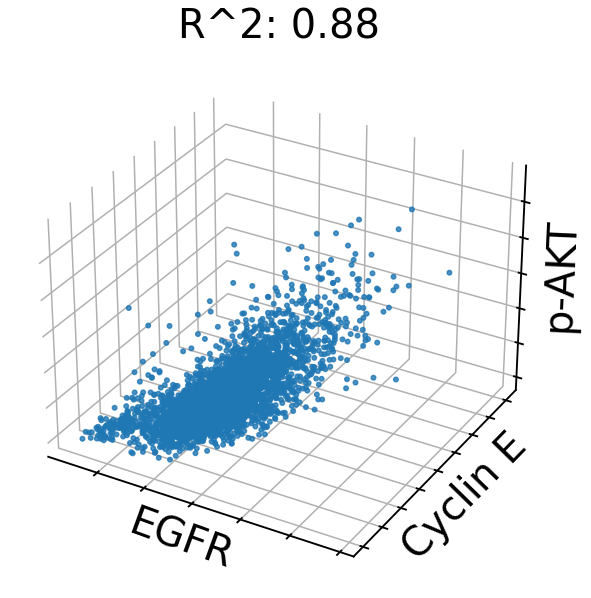

In [35]:
import statsmodels.api as sm

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection = '3d')

x_marker = 'Cyclin E'
y_marker = 'EGFR'
z_marker = 'p-AKT'
x = df_cell[x_marker]
y = df_cell[y_marker]
z = df_cell[z_marker]

model = sm.OLS(z,np.stack([x,y]).T)
results = model.fit()
print(results.rsquared_adj)

ax.set_xlabel(y_marker, fontsize=40, rotation=-20)
ax.set_ylabel(x_marker, fontsize=40, rotation=50)
ax.set_zlabel(z_marker, fontsize=40, rotation=88)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.scatter(y, x, z, alpha=0.8)

plt.title(f'R^2: {results.rsquared_adj:.2f}', fontsize=40)


0.9028659679432296


Text(0.5, 0.92, 'R^2: 0.90')

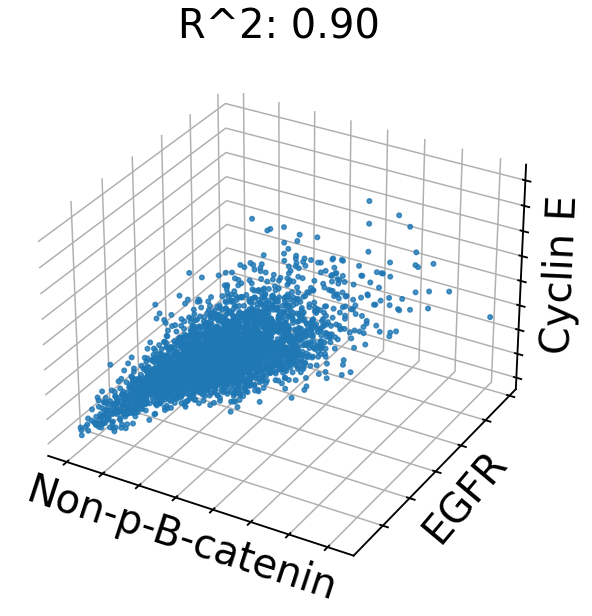

In [34]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection = '3d')

x_marker = 'EGFR'
y_marker = 'Non-p-B-catenin'
z_marker = 'Cyclin E'
x = df_cell[x_marker]
y = df_cell[y_marker]
z = df_cell[z_marker]

model = sm.OLS(z,np.stack([x,y]).T)
results = model.fit()
print(results.rsquared_adj)

ax.set_xlabel(y_marker, fontsize=40, rotation=-20)
ax.set_ylabel(x_marker, fontsize=40, rotation=50)
ax.set_zlabel(z_marker, fontsize=40, rotation=88)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.scatter(y, x, z, alpha=0.8)

plt.title(f'R^2: {results.rsquared_adj:.2f}', fontsize=40)

